In [1]:
import pandas as pd
import os
from os.path import isfile, join

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import numpy as np

import matplotlib.pyplot as plt

from lib.drawing import hist_compare

In [2]:
# show all rows
pd.options.display.max_rows = 999

In [3]:
# read data file
datafolder = 'data/'
datafile = 'myo5b_variants_patho_benign_cadd1.3fullannot_v1.xlsx'
datatable = pd.ExcelFile(os.path.join(datafolder,datafile))
datatable_pd = datatable.parse(datatable.sheet_names[0])
pos = datatable_pd['POS']

In [4]:
# display data
datatable_pd.shape

(248, 117)

In [5]:
for i in range(0,len(datatable_pd.columns),5):
    print(datatable_pd.columns[i:i+5].values)

['CHROM' 'POS' 'ID' 'REF' 'ALT']
['INFO' 'Type' 'Length' 'isTv' 'isDerived']
['AnnoType' 'Consequence' 'ConsScore' 'ConsDetail' 'GC']
['CpG' 'mapAbility20bp' 'mapAbility35bp' 'scoreSegDup' 'priPhCons']
['mamPhCons' 'verPhCons' 'priPhyloP' 'mamPhyloP' 'verPhyloP']
['GerpN' 'GerpS' 'GerpRS' 'GerpRSpval' 'bStatistic']
['mutIndex' 'dnaHelT' 'dnaMGW' 'dnaProT' 'dnaRoll']
['mirSVR-Score' 'mirSVR-E' 'mirSVR-Aln' 'targetScan' 'fitCons']
['cHmmTssA' 'cHmmTssAFlnk' 'cHmmTxFlnk' 'cHmmTx' 'cHmmTxWk']
['cHmmEnhG' 'cHmmEnh' 'cHmmZnfRpts' 'cHmmHet' 'cHmmTssBiv']
['cHmmBivFlnk' 'cHmmEnhBiv' 'cHmmReprPC' 'cHmmReprPCWk' 'cHmmQuies']
['EncExp' 'EncH3K27Ac' 'EncH3K4Me1' 'EncH3K4Me3' 'EncNucleo']
['EncOCC' 'EncOCCombPVal' 'EncOCDNasePVal' 'EncOCFairePVal'
 'EncOCpolIIPVal']
['EncOCctcfPVal' 'EncOCmycPVal' 'EncOCDNaseSig' 'EncOCFaireSig'
 'EncOCpolIISig']
['EncOCctcfSig' 'EncOCmycSig' 'Segway' 'tOverlapMotifs' 'motifDist']
['motifECount' 'motifEName' 'motifEHIPos' 'motifEScoreChng' 'TFBS']
['TFBSPeaks' 'TFB

In [6]:
# delete some columns that were not used in cadd paper
del_cols = ['CHROM','POS','ID','isDerived','AnnoType','ConsScore',
            'ConsDetail','mapAbility20bp','mapAbility35bp',
            'scoreSegDup','isKnownVariant','ESP_AF','ESP_AFR',
            'ESP_EUR','TG_AF','TG_ASN','TG_AMR','TG_AFR','TG_EUR',
            'GeneID','FeatureID','CCDS','GeneName','Exon',
            'Intron']
datatable_pd = datatable_pd.drop(columns=del_cols)

# delete columns without a single value
datatable_pd = datatable_pd.dropna(axis=1,how='all')
print(datatable_pd.shape)

(248, 87)


In [7]:
print(datatable_pd.shape)

(248, 87)


In [8]:
# check missing values for object data
print('{0: <5}  {1: <5}  {2: <5}  {3: <5}  {4: <5}'.format('column','nr_of_null',
                                                           'most_often','freq','unique'))
for column in datatable_pd.select_dtypes(include=[np.object]).columns:
    null = datatable_pd[column].isnull().values.ravel().sum()
    if null > 0:
        print('{}  {}  {}  {}  {}'.format(column,null,
                                          datatable_pd[column].describe().top,
                                          datatable_pd[column].describe().freq,
                                          datatable_pd[column].unique()))
# exclude 'GeneID', 'CCDS', 'GeneName'
# leave other missing values missing

column  nr_of_null  most_often  freq   unique
isTv  30  False  134  [False nan True]
Domain  73  ndomain  144  [nan 'ndomain' 'ncoils']
Dst2SplType  160  ACCEPTOR  49  [nan 'DONOR' 'ACCEPTOR']
oAA  78  R  28  [nan 'Q' 'R' 'L' '-' 'AR' 'P' 'I' 'F' 'C' 'N' 'G' 'W' 'S' 'A' 'V' 'M' 'T'
 'Y' 'K' 'E' 'D' 'H']
nAA  78  *  34  [nan '*' 'R' 'P' 'G' 'L' 'C' 'F' 'S' 'W' 'H' 'V' 'E' 'M' 'Y' 'N' 'I' 'A'
 'Q' 'T' 'K' 'D']
PolyPhenCat  141  benign  52  [nan 'probably_damaging' 'benign' 'possibly_damaging']
SIFTcat  141  tolerated  56  [nan 'deleterious' 'tolerated']


In [9]:
# check missing values for numerical data
for column in datatable_pd.select_dtypes(exclude=[np.object]).columns:
    null = datatable_pd[column].isnull().values.ravel().sum()
    if null > 0:
#         print(column)
        print('%s\t%s\t%s'%(column, null,datatable_pd[column].mean()))

GerpRS	32	549.744907407
GerpRSpval	32	1.23679239352e-10
mirSVR-Score	230	-0.274188888889
mirSVR-E	230	-12.3311111111
mirSVR-Aln	230	141.444444444
EncExp	8	32.2477916667
EncOCC	220	3.21428571429
EncOCCombPVal	220	2.66035714286
EncOCDNasePVal	220	2.63392857143
EncOCFairePVal	220	0.73
EncOCpolIIPVal	220	0.399285714286
EncOCctcfPVal	220	2.21535714286
EncOCmycPVal	220	1.10928571429
EncOCDNaseSig	220	0.107142857143
EncOCFaireSig	220	0.0132142857143
EncOCpolIISig	220	0.0114285714286
EncOCctcfSig	220	0.265
EncOCmycSig	220	0.0635714285714
tOverlapMotifs	241	4.0
motifDist	241	-0.131428571429
TFBS	227	3.42857142857
TFBSPeaks	227	4.04761904762
TFBSPeaksMax	227	57.8333047619
cDNApos	40	2675.76923077
relcDNApos	40	0.281442307692
CDSpos	58	1958.24736842
relCDSpos	58	0.353157894737
protPos	58	653.152631579
relProtPos	58	0.353684210526
Dst2Splice	160	3.47727272727
Grantham	141	75.2242990654
PolyPhenVal	141	0.474037383178
SIFTval	141	0.199439252336


In [10]:
# fill in values recommended by cadd paper
values = {'GerpRS':0, 'GerpRSpval':1,'EncExp':0,'EncOCC':5,'EncOCCombPVal':0,
          'EncOCDNasePVal':0,'EncOCFairePVal':0,'EncOCpolIIPVal':0,'EncOCctcfPVal':0,
          'EncOCmycPVal':0,'EncOCDNaseSig':0,'EncOCFaireSig':0,'EncOCpolIISig':0,
          'EncOCctcfSig':0,'EncOCmycSig':0,'tOverlapMotifs':0,'motifDist':0,
          'TFBS':0,'TFBSPeaksMax':0,'PolyPhenVal':0,'SIFTval':0,'TFBSPeaks':0}
datatable_pd = datatable_pd.fillna(values)
# check again the missing values for numerical data after fillna
for column in datatable_pd.select_dtypes(exclude=[np.object]).columns:
    null = datatable_pd[column].isnull().values.ravel().sum()
    if null > 0:
        print('%s\t%s\t%.2f\t%.2f'%(column, null,datatable_pd[column].mean(),datatable_pd[column].min()))

mirSVR-Score	230	-0.27	-1.09
mirSVR-E	230	-12.33	-24.38
mirSVR-Aln	230	141.44	120.00
cDNApos	40	2675.77	301.00
relcDNApos	40	0.28	0.03
CDSpos	58	1958.25	1.00
relCDSpos	58	0.35	0.00
protPos	58	653.15	1.00
relProtPos	58	0.35	0.00
Dst2Splice	160	3.48	-15.00
Grantham	141	75.22	0.00


In [11]:
# check again the missing values for numerical data after fillna
for column in datatable_pd.select_dtypes(include=[np.object]).columns:
    null = datatable_pd[column].isnull().values.ravel().sum()
    if null > 0:
        print('%s\t%s\t%s'%(column, null,datatable_pd[column].unique()))

isTv	30	[False nan True]
Domain	73	[nan 'ndomain' 'ncoils']
Dst2SplType	160	[nan 'DONOR' 'ACCEPTOR']
oAA	78	[nan 'Q' 'R' 'L' '-' 'AR' 'P' 'I' 'F' 'C' 'N' 'G' 'W' 'S' 'A' 'V' 'M' 'T'
 'Y' 'K' 'E' 'D' 'H']
nAA	78	[nan '*' 'R' 'P' 'G' 'L' 'C' 'F' 'S' 'W' 'H' 'V' 'E' 'M' 'Y' 'N' 'I' 'A'
 'Q' 'T' 'K' 'D']
PolyPhenCat	141	[nan 'probably_damaging' 'benign' 'possibly_damaging']
SIFTcat	141	[nan 'deleterious' 'tolerated']


In [12]:
# transform objects to dummies
categorical_feature_names = datatable_pd.select_dtypes(include=np.object).columns
categories={} # contains all the levels in those feature columns
for f in categorical_feature_names:
    datatable_pd[f] = datatable_pd[f].astype('category')
    categories[f] = datatable_pd[f].cat.categories

dummy_data = pd.get_dummies(datatable_pd,columns=[col for col in categorical_feature_names 
                                                  if col not in ['INFO']])
# change info column into scalar column
dummy_data['INFO'] = datatable_pd['INFO'].astype('category').cat.codes
print(dummy_data.shape)

(248, 193)


In [13]:
# drop nan values
dummy_data_del_all_nan = dummy_data.copy()
for col in dummy_data.columns:
    null = dummy_data[col].isnull().values.ravel().sum()
    if null > 0:
        dummy_data_del_all_nan = dummy_data_del_all_nan.drop(columns=col)
print(dummy_data_del_all_nan.shape)

(248, 182)


In [14]:
# normalized the numerical values before any processing afterwards
min_max_scaler = preprocessing.MinMaxScaler()
dummy_data_scaled = min_max_scaler.fit_transform(dummy_data_del_all_nan)
dummy_data_scaled = pd.DataFrame(dummy_data_scaled,columns=dummy_data_del_all_nan.columns)

In [18]:
# save the preprocessed data as csv file
dummy_data_scaled.to_csv('data/dummy_no_nan_data.csv',sep='\t',index=False)

In [19]:
# save the preprocessed data as csv file
dummy_data_scaled_withpos = dummy_data_scaled
dummy_data_scaled_withpos['POS'] = pos
dummy_data_scaled_withpos.to_csv('data/dummy_no_nan_data_withpos.csv',sep='\t',index=False)

In [19]:
# split train and test datasets
train, test = train_test_split(dummy_data_scaled,test_size=0.25)
print(train.shape, test.shape)
train_x = train[[col for col in train.columns if col not in ['INFO']]]
train_y = train['INFO']
test_x = test[[col for col in test.columns if col not in ['INFO']]]
test_y = test['INFO']
print(train_x.shape)

(186, 182) (62, 182)
(186, 181)


[[41  5]
 [12  4]]


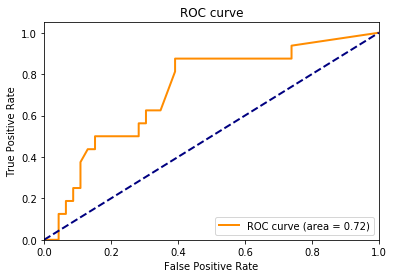

In [20]:
# randomforest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=5,class_weight={1:6,0:1})
clf.fit(train_x, train_y)
# try deleting all columns with missing values and logistic regression etc methods
pred = clf.predict(test_x)
preds = clf.predict_proba(test_x)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)
score = metrics.auc(fpr,tpr)
print(confusion_matrix(test_y,pred))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

tp fn fp tn
8  7 8  39
auc is 0.704255319149


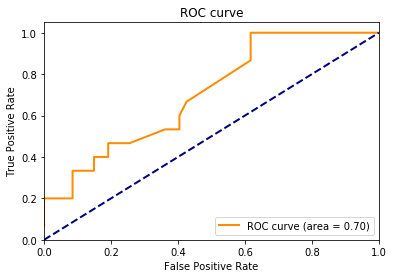

In [18]:
# logistic regression models example for the dummies
logr = LogisticRegression(penalty='l1',C=3,class_weight={1:2,0:1})
logr.fit(train_x,train_y)
pred = logr.predict(test_x)
tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))
preds = clf.predict_proba(test_x)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)
print('auc is',metrics.auc(fpr,tpr))
# tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
print(tpr)
print(fpr)

[ 0.      0.      0.      0.125   0.125   0.1875  0.1875  0.25    0.25
  0.375   0.4375  0.4375  0.5     0.5     0.5     0.5     0.5625  0.5625
  0.625   0.625   0.8125  0.875   0.875   0.875   0.875   0.875   0.875
  0.9375  1.    ]
[ 0.          0.02173913  0.04347826  0.04347826  0.06521739  0.06521739
  0.08695652  0.08695652  0.10869565  0.10869565  0.13043478  0.15217391
  0.15217391  0.19565217  0.26086957  0.2826087   0.2826087   0.30434783
  0.30434783  0.34782609  0.39130435  0.39130435  0.43478261  0.63043478
  0.65217391  0.7173913   0.73913043  0.73913043  1.        ]


tp fn fp tn
0  16 0  46
auc is 0.723505434783


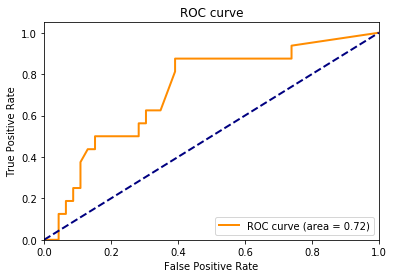

In [22]:
# elastic net
from sklearn.linear_model import ElasticNet
logr = ElasticNet(alpha=0.5,l1_ratio=0.5)
logr.fit(train_x,train_y)
pred = logr.predict(test_x)
clas_pred = np.zeros((len(pred),1))
clas_pred[pred>pred.mean()] = 1
tn, fp, fn, tp = confusion_matrix(test_y,clas_pred).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))
preds = clf.predict_proba(test_x)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)
print('auc is',metrics.auc(fpr,tpr))
# tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
logr

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [22]:
print(logr)

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [23]:
# gridsearchCV for the dataset
param_grid = {'penalty':['l1','l2'],'C':[1,2,3,4,5]}
classifier = GridSearchCV(estimator=LogisticRegression(),
                          param_grid=param_grid)
classifier.fit(train_x,train_y)
pred = classifier.predict(test_x)
tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))
preds = classifier.predict_proba(test_x)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)
print('auc is',metrics.auc(fpr,tpr))

tp fn fp tn
3  13 4  42
auc is 0.648097826087


In [24]:
# pca
pca = PCA()
pca.fit(train_x)
print(pca.explained_variance_ratio_[:3])
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)
print(train_x_pca.shape)

[ 0.12030859  0.08030165  0.06028698]
(186, 181)


tp fn fp tn
8  8 14  32
0.654891304348


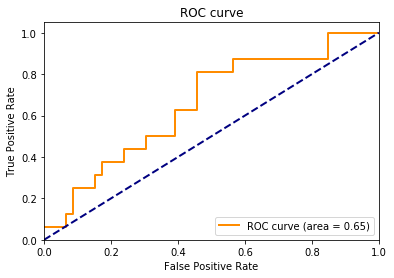

In [25]:
# pca + LogisticRegression
param_grid = {'penalty':['l1','l2'],'C':[1,2,3,4,5],'tol':[1e-3,1e-4,1e-5]}
classifier = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                          param_grid=param_grid)
classifier.fit(train_x_pca,train_y)
pred = classifier.predict(test_x_pca)
tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))
preds = classifier.predict_proba(test_x_pca)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)
score = metrics.auc(fpr,tpr)
print(score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


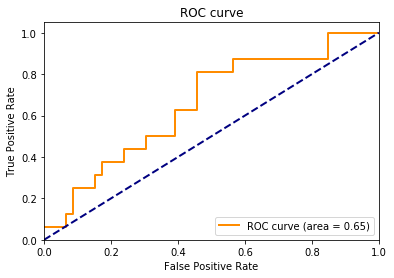

In [26]:
# ranfor cv
param_grid = {'max_depth':[2,3,4,5,6,7,8],
              'n_estimators':[50,100]}
ranfor = GridSearchCV(estimator=RandomForestClassifier(),
                      param_grid=param_grid)
ranfor.fit(train_x_pca,train_y)
print(ranfor.best_estimator_)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
# svm
svm = SVC()
svm.fit(train_x, train_y)
pred = svm.predict(test_x)
tn, fp, fn, tp = confusion_matrix(test_y,pred).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))

tp fn fp tn
0  15 0  47


In [33]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ranfor, train_x_pca, train_y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.03)


In [47]:
from sklearn.linear_model import ElasticNet
encv = ElasticNet(l1_ratio=0.5, random_state=0)
encv.fit(train_x,train_y)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [48]:
encv.score(train_x,train_y)

0.13430941402950569

In [ ]:
# pca+LinearRegression
# cv results


In [ ]:
# pca+ElasticNet
# cv results

In [ ]:
# pca+RandomForest
# cv results